# Dataset Loading

In [ ]:
!kaggle datasets download -d bogdanpetre98/aadb-imagedatabase

Dataset URL: https://www.kaggle.com/datasets/bogdanpetre98/aadb-imagedatabase
License(s): unknown
 99% 131M/132M [00:01<00:00, 90.2MB/s]
100% 132M/132M [00:01<00:00, 73.6MB/s]


In [ ]:
import zipfile
import os
File = 'aadb-imagedatabase.zip'
# Unzipping the file
with zipfile.ZipFile(File, 'r') as zip_ref:
    zip_ref.extractall('AADB Dataset')

# List the contents of the extracted directory
os.listdir('AADB Dataset')

['datasetImages_warp256', 'Dataset_test.csv', 'Dataset.csv']

In [ ]:
import pandas as pd

data = pd.read_csv('/content/AADB Dataset/Dataset.csv')
data.head()

,ImageFile,BalacingElements,ColorHarmony,Content,DoF,Light,MotionBlur,Object,Repetition,RuleOfThirds,Symmetry,VividColor,score
0,farm1_333_19438364933_087c8abc60_b.jpg,-0.2,0.2,-0.2,-0.4,0.0,0.0,-0.4,0.0,-0.2,0.0,0.0,0.30
1,farm1_452_19898743300_201156d984_b.jpg,0.2,0.4,0.6,-0.2,0.2,0.0,0.6,0.0,0.8,0.0,0.4,0.70
2,farm1_281_20247100976_c8141d3653_b.jpg,-0.2,0.0,0.4,-0.2,-0.4,0.0,-0.6,0.0,-0.4,0.0,0.6,0.40
3,farm1_448_19709457333_be4c6bb5eb_b.jpg,0.0,0.6,-0.6,-0.2,0.0,0.0,0.2,0.2,0.0,0.0,0.4,0.60
4,farm1_393_20179744375_c119001350_b.jpg,-0.2,0.6,0.4,0.0,-0.4,0.0,0.2,0.0,0.0,0.0,0.2,0.45


# EDA

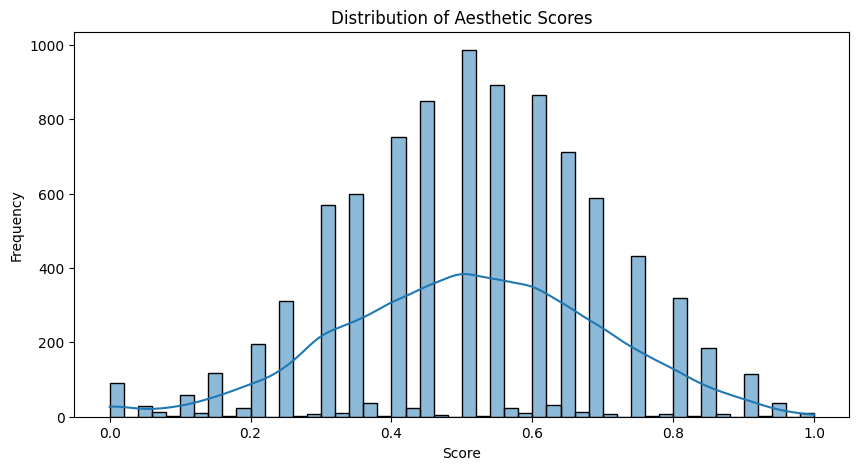

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Distribution of scores
plt.figure(figsize=(10, 5))
sns.histplot(data['score'], bins=50, kde=True)
plt.title('Distribution of Aesthetic Scores')
plt.xlabel('Score')
plt.ylabel('Frequency')
plt.show()

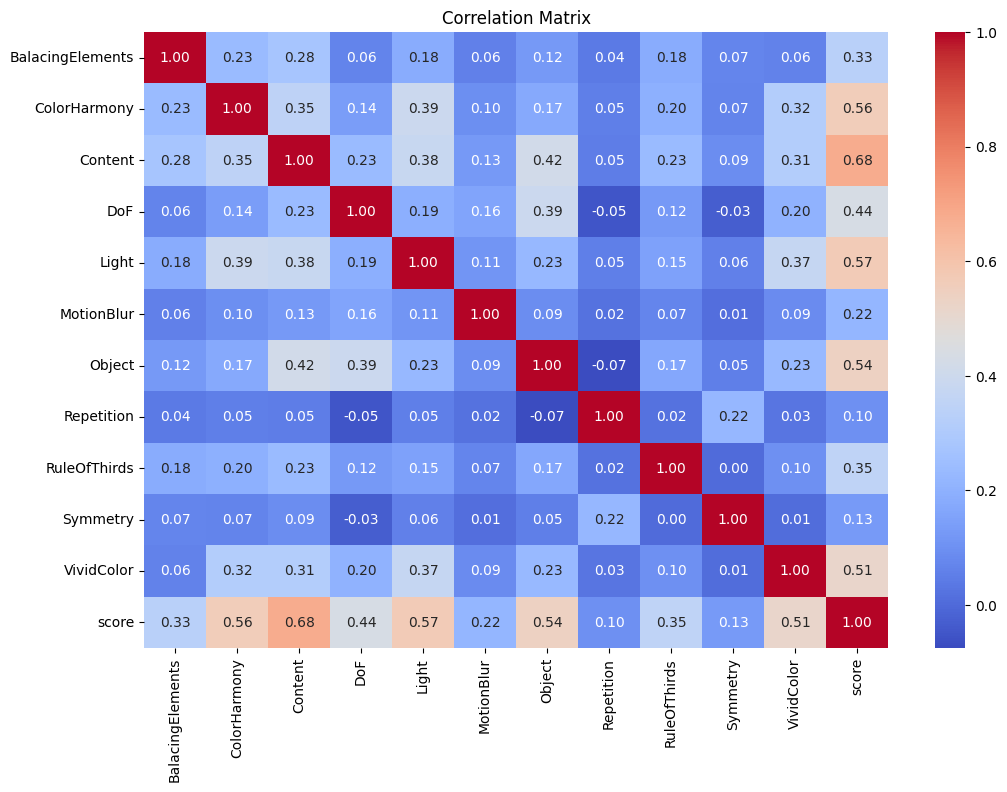

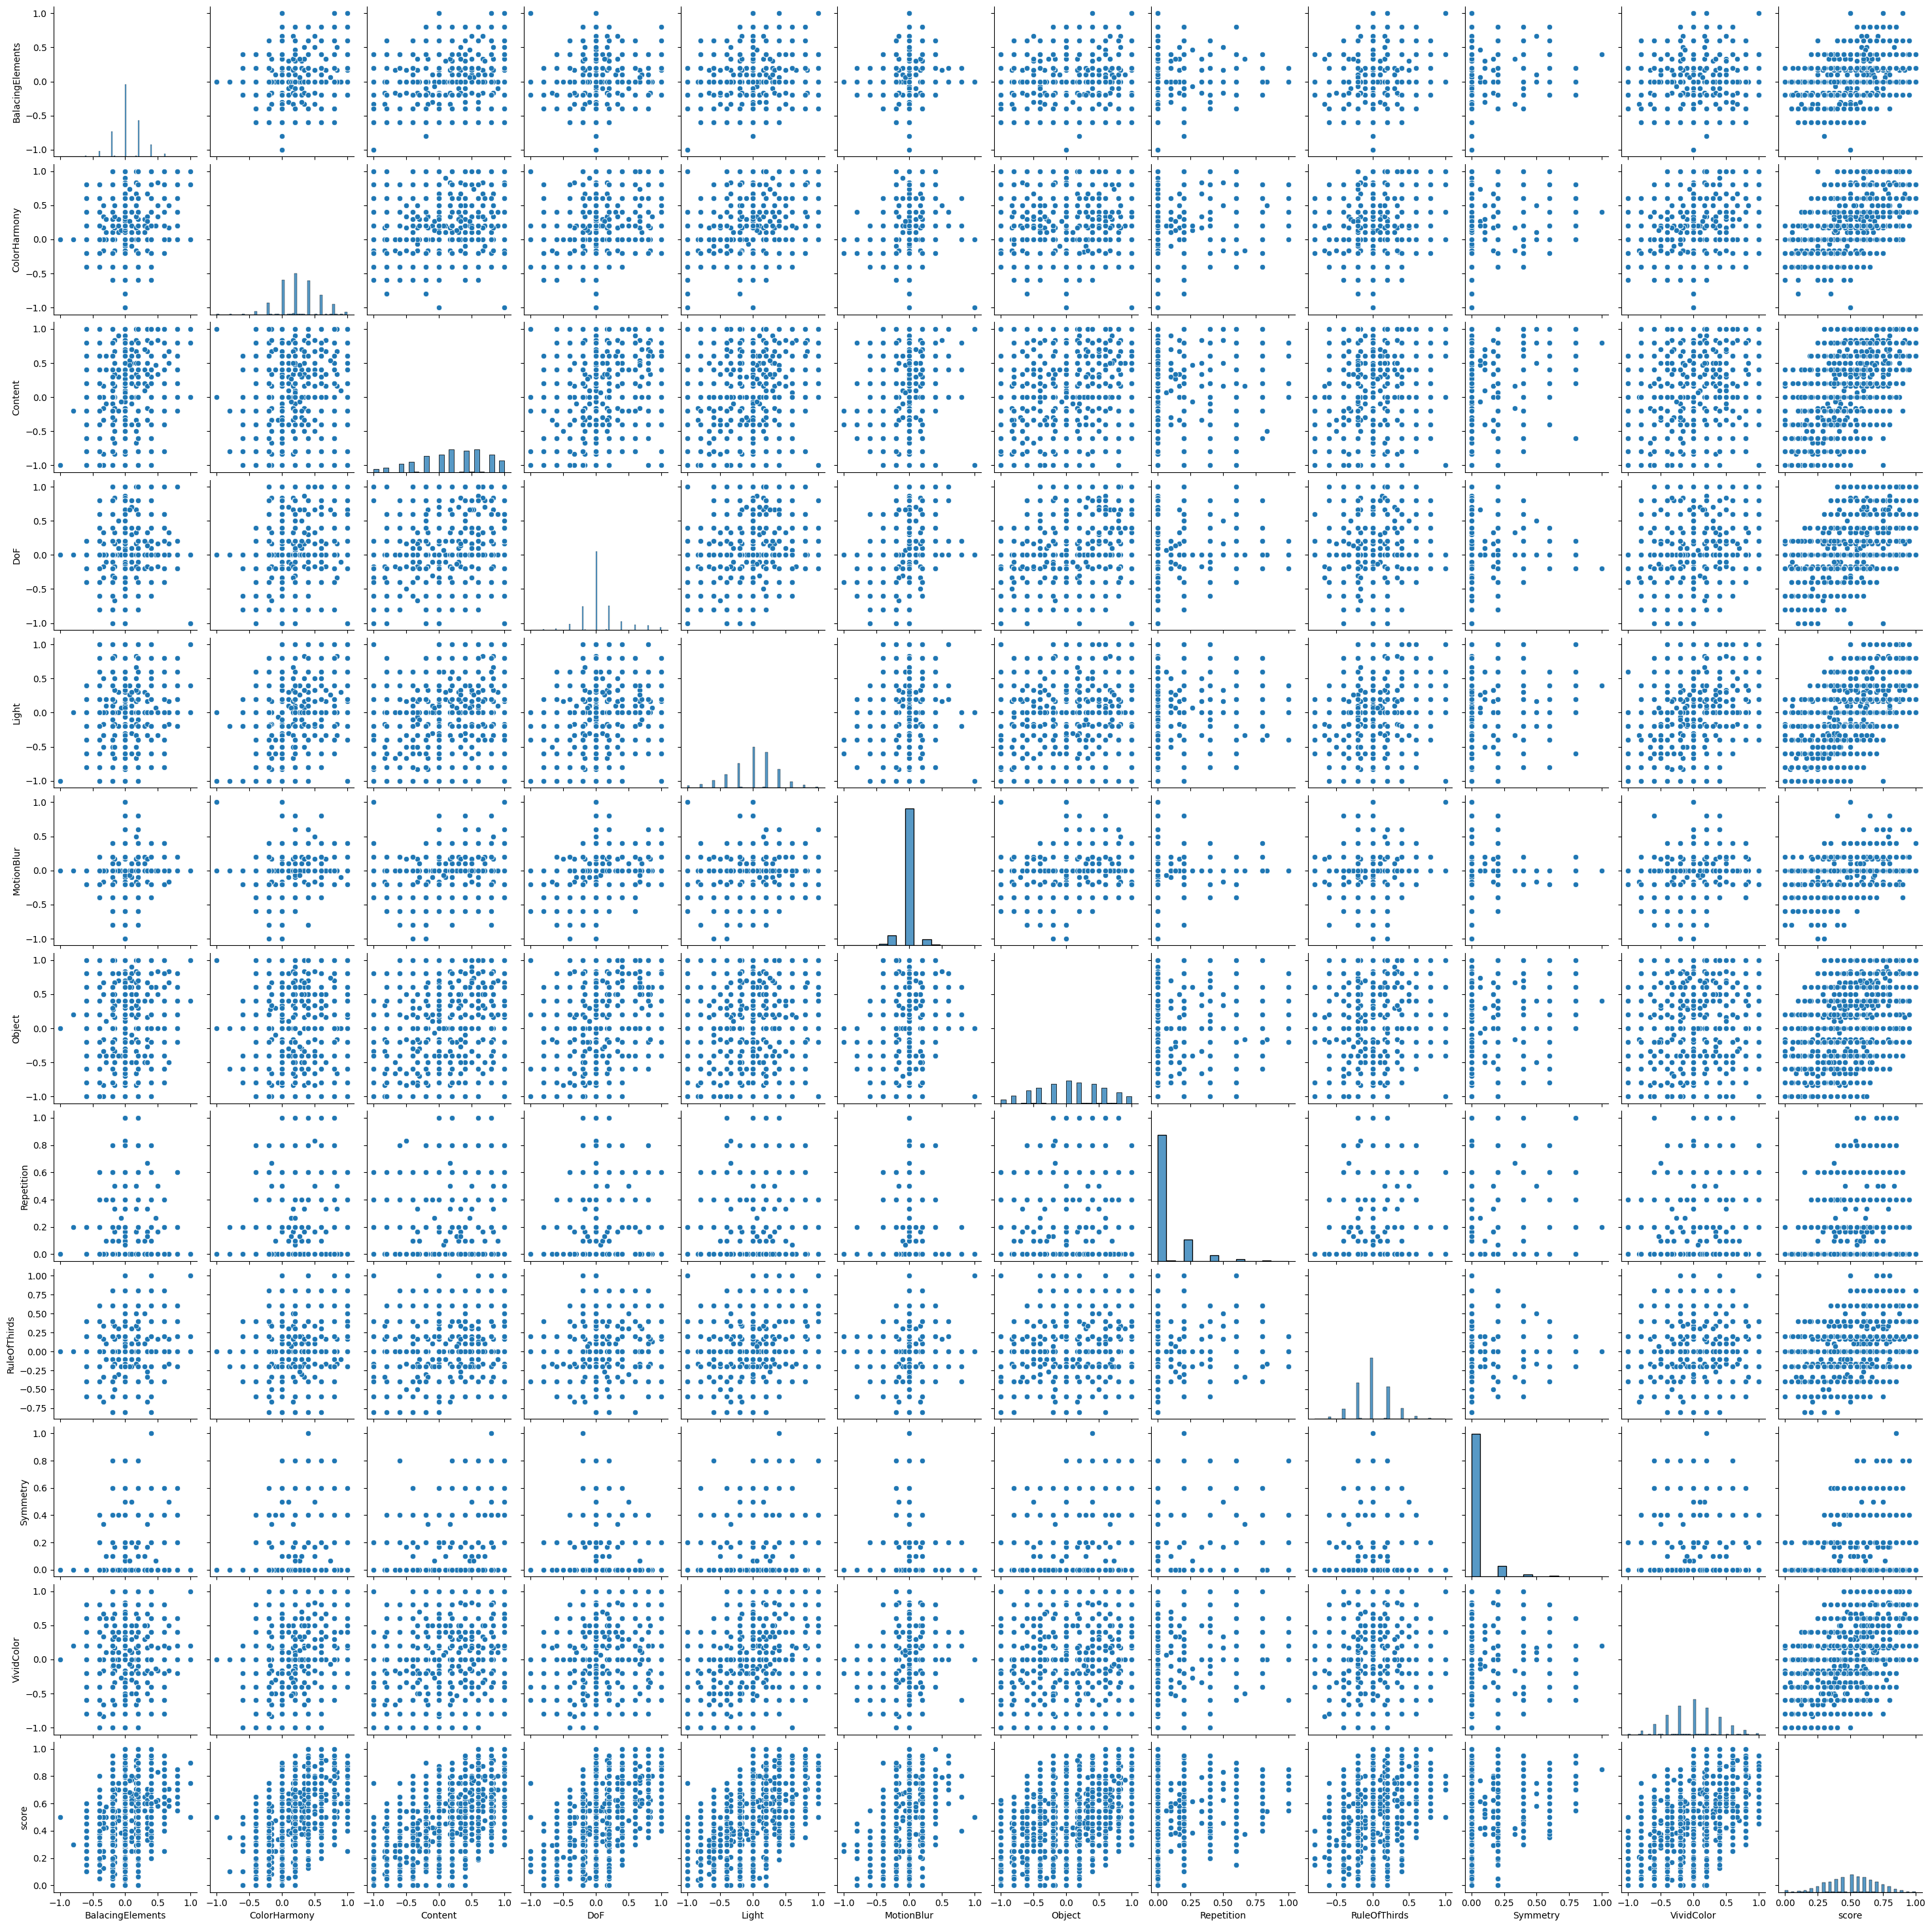

In [ ]:
# Correlation matrix excluding the 'ImageFile' column
corr_matrix = data.drop(columns=['ImageFile']).corr()

# Plot the heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

# Pairplot
sns.pairplot(data.drop(columns=['ImageFile']))
plt.show()

In [ ]:
# Define the path to the image folder
image_folder = '/content/AADB Dataset/datasetImages_warp256/datasetImages_warp256'

In [ ]:
import tensorflow as tf
# Define the image size
image_size = (224, 224)

# Preprocess the images
def preprocess_image(image_name, label):
    image_path = os.path.join(image_folder, image_name.numpy().decode('utf-8'))
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, image_size)
    image /= 255.0
    return image, tf.cast(label, tf.float32)

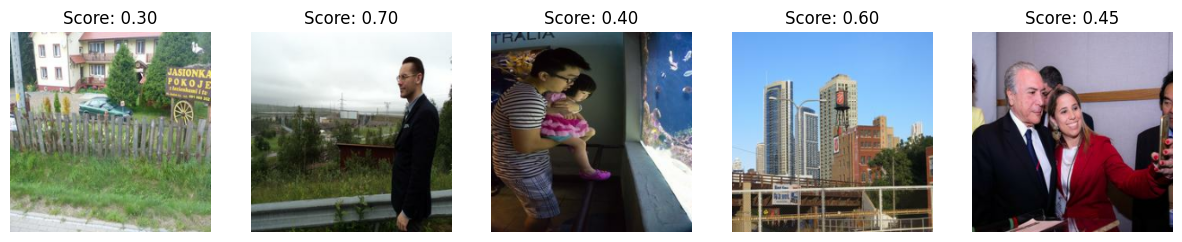

In [ ]:
import matplotlib.pyplot as plt

# Function to preprocess and load images
def load_and_preprocess_image(image_name):
    image_path = os.path.join(image_folder, image_name)
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, (224, 224))
    image /= 255.0  # Normalize to [0, 1]
    return image

# Display a few sample images with their labels
def visualize_images(data, num_images=5):
    plt.figure(figsize=(15, 10))
    for i in range(num_images):
        image_name = data['ImageFile'].iloc[i]
        label = data['score'].iloc[i]
        image = load_and_preprocess_image(image_name)

        plt.subplot(1, num_images, i+1)
        plt.imshow(image)
        plt.title(f'Score: {label:.2f}')
        plt.axis('off')
    plt.show()

# Visualize the first 5 images in the dataset
visualize_images(data, num_images=5)

# Model Building

In [ ]:
from sklearn.model_selection import train_test_split
# Split the data into training and validation sets
train_df, val_df = train_test_split(data, test_size=0.2, random_state=42)

In [ ]:
from tensorflow.keras.applications import InceptionResNetV2
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Input
from tensorflow.keras.models import Model

# Load pre-trained model
base_model = InceptionResNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the base model
base_model.trainable = False

# Add custom layers
inputs = Input(shape=(224, 224, 3))
x = base_model(inputs, training=False)
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(1, activation='linear')(x)

# Create the model
model = Model(inputs, predictions)

# Compile the model
model.compile(optimizer='adam', loss='mean_absolute_error')

219055592/219055592 [==============================] - 1s 0us/step


In [ ]:
!pip install pydot graphviz

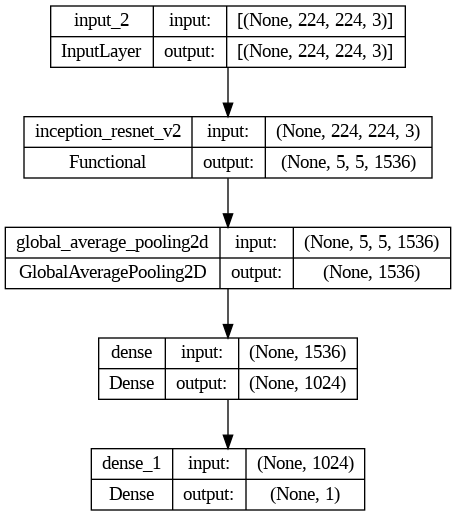

In [ ]:
from tensorflow.keras.utils import plot_model

# Plot the model architecture
plot_model(model, to_file='model_architecture.png', show_shapes=True, show_layer_names=True)

# Display the plot (if running in a notebook environment)
from IPython.display import Image
Image('model_architecture.png')


In [ ]:
# Create TensorFlow datasets
def create_dataset(dataframe):
    image_paths = dataframe['ImageFile'].values
    labels = dataframe['score'].values
    dataset = tf.data.Dataset.from_tensor_slices((image_paths, labels))
    dataset = dataset.map(lambda x, y: tf.py_function(func=preprocess_image, inp=[x, y], Tout=[tf.float32, tf.float32]))
    dataset = dataset.batch(32).prefetch(buffer_size=tf.data.AUTOTUNE)
    return dataset

In [ ]:
train_dataset = create_dataset(train_df)
val_dataset = create_dataset(val_df)